In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import glob
from mpl_toolkits.mplot3d import Axes3D
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
import os
import shutil
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Question 1

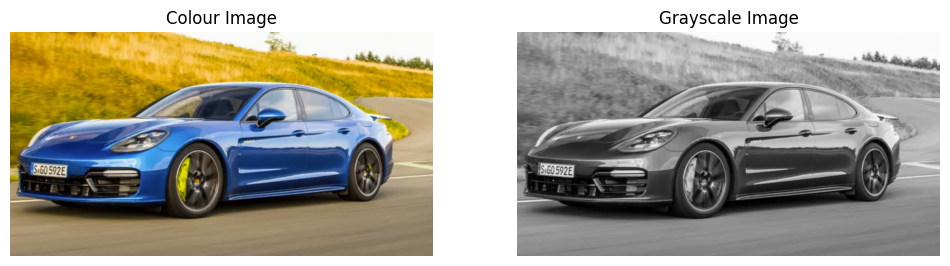

In [2]:
# Question 1.1: Take an image, read it in color and grayscale
image = cv2.imread(r'C:\Users\devTe\Desktop\MAS512\Assignment1\images\porche_panamera_blue.jpg') # Add the correct path to the image, 
#I have two images in the folder, one is in color red and second blue
image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Display the color and grayscale images side by side (Figure 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title('Colour Image')
ax[0].axis('off')

ax[1].imshow(image_grayscale, cmap='gray')
ax[1].set_title('Grayscale Image')
ax[1].axis('off')

plt.show()

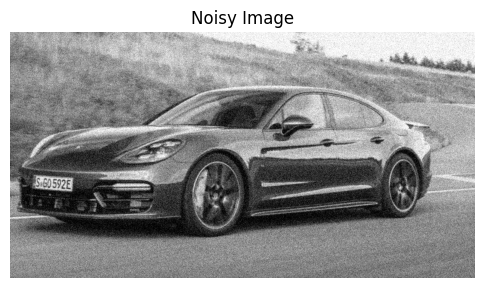

In [9]:
# Question 1.2 - Adding Gaussian noise to the grayscale image
mean = 0
stddev = 25
noise = np.random.normal(mean, stddev, image_grayscale.shape)
noisy_image = image_grayscale + noise
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
# Display the noisy image (Figure 2)
plt.figure(figsize=(6, 6))
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.show()


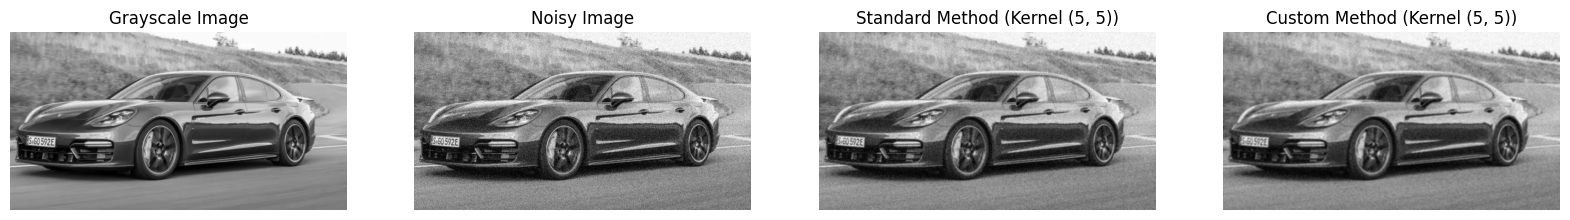

In [10]:
# Question 1.3 & 1.4: Noise removal using standard (Gaussian Blur) and custom kernel methods
def custom_kernel_blur(image, kernel_size):
    kernel = np.ones(kernel_size, np.float32) / (kernel_size[0] * kernel_size[1])
    return cv2.filter2D(image, -1, kernel)

# Apply noise removal with kernel (5,5)
kernel_size = (5, 5)
noiseremove_image_standard = cv2.GaussianBlur(noisy_image, kernel_size, 0)
noiseremove_image_kernel = custom_kernel_blur(noisy_image, kernel_size)

# Display Grayscale, Noisy, Standard noise removal, and Custom noise removal (Figure 2)
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

ax[0].imshow(image_grayscale, cmap='gray')
ax[0].set_title('Grayscale Image')
ax[0].axis('off')

ax[1].imshow(noisy_image, cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

ax[2].imshow(noiseremove_image_standard, cmap='gray')
ax[2].set_title(f'Standard Method (Kernel {kernel_size})')
ax[2].axis('off')

ax[3].imshow(noiseremove_image_kernel, cmap='gray')
ax[3].set_title(f'Custom Method (Kernel {kernel_size})')
ax[3].axis('off')

plt.show()

SSIM (Gaussian Blur): 0.7536
SSIM (Custom Kernel): 0.8066


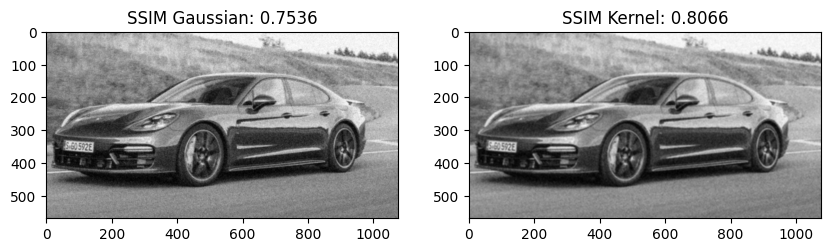

In [11]:
# Question 1.5 - SSIM comparison between the two methods
ssim_standard = ssim(image_grayscale, noiseremove_image_standard)
ssim_kernel = ssim(image_grayscale, noiseremove_image_kernel)

print(f'SSIM (Gaussian Blur): {ssim_standard:.4f}')
print(f'SSIM (Custom Kernel): {ssim_kernel:.4f}')

# Plot the comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(noiseremove_image_standard, cmap='gray')
ax[0].set_title(f'SSIM Gaussian: {ssim_standard:.4f}')

ax[1].imshow(noiseremove_image_kernel, cmap='gray')
ax[1].set_title(f'SSIM Kernel: {ssim_kernel:.4f}')

plt.show()

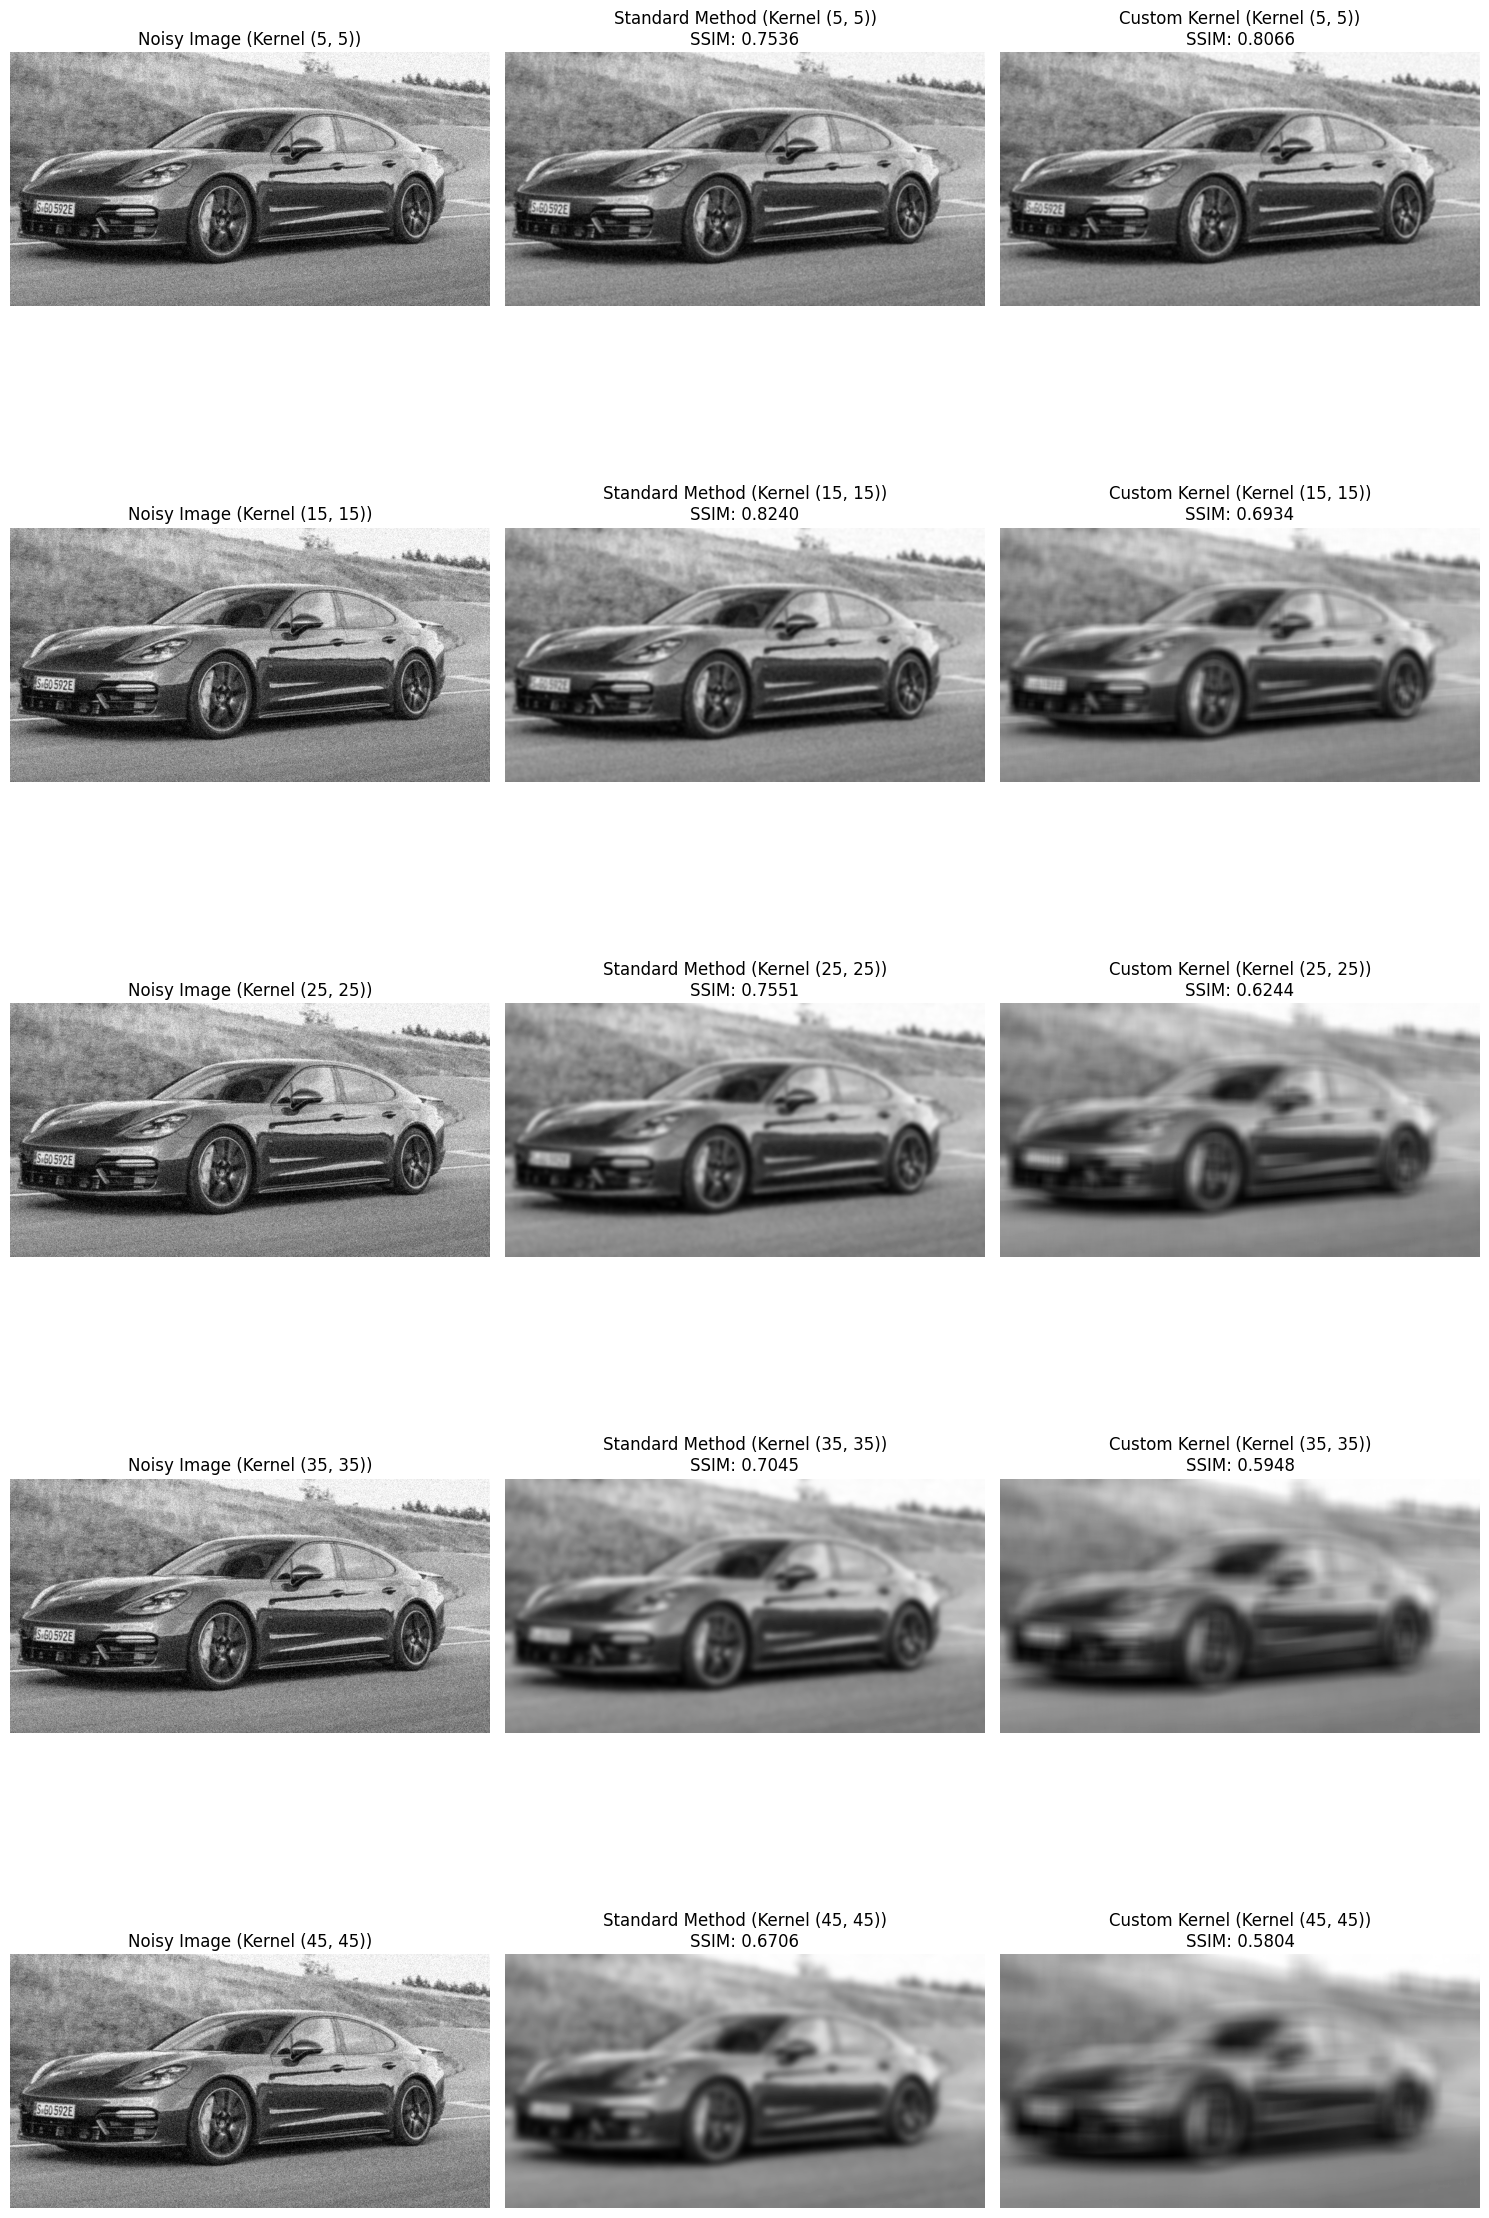

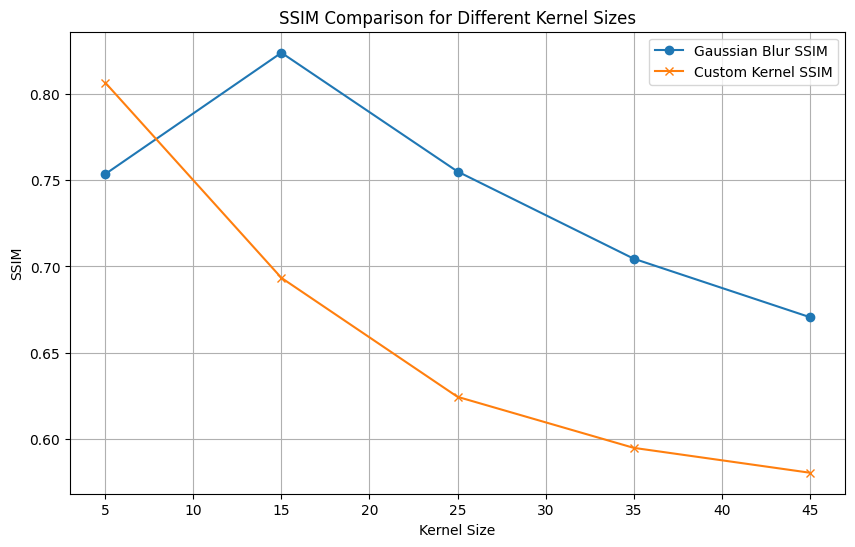

In [12]:
# Question 1.6: Create an array of kernel sizes (from 5 to 50, step 10 with odd values)
kernel_sizes = [(i, i) for i in range(5, 55, 10)]  # [(5, 5), (15, 15), ..., (45, 45)]

# Initialize lists to store SSIM values for each method
ssim_standard_list = []
ssim_kernel_list = []

# Plot the results in a single figure with multiple subplots
fig, ax = plt.subplots(len(kernel_sizes), 3, figsize=(15, len(kernel_sizes) * 5))

for i, kernel_size in enumerate(kernel_sizes):
    # Apply Gaussian Blur (Standard method)
    noiseremove_image_standard = cv2.GaussianBlur(noisy_image, kernel_size, 0)
    
    # Apply Custom Kernel Blur
    noiseremove_image_kernel = custom_kernel_blur(noisy_image, kernel_size)
    
    # Compute SSIM for both methods
    ssim_standard = ssim(image_grayscale, noiseremove_image_standard)
    ssim_kernel = ssim(image_grayscale, noiseremove_image_kernel)
    
    # Store SSIM values for plotting later
    ssim_standard_list.append(ssim_standard)
    ssim_kernel_list.append(ssim_kernel)
    
    # Plot results for each kernel size
    ax[i, 0].imshow(noisy_image, cmap='gray')
    ax[i, 0].set_title(f'Noisy Image (Kernel {kernel_size})')
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(noiseremove_image_standard, cmap='gray')
    ax[i, 1].set_title(f'Standard Method (Kernel {kernel_size})\nSSIM: {ssim_standard:.4f}')
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(noiseremove_image_kernel, cmap='gray')
    ax[i, 2].set_title(f'Custom Kernel (Kernel {kernel_size})\nSSIM: {ssim_kernel:.4f}')
    ax[i, 2].axis('off')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

# Plot SSIM comparison for different kernel sizes
plt.figure(figsize=(10, 6))
plt.plot([size[0] for size in kernel_sizes], ssim_standard_list, label='Gaussian Blur SSIM', marker='o')
plt.plot([size[0] for size in kernel_sizes], ssim_kernel_list, label='Custom Kernel SSIM', marker='x')
plt.xlabel('Kernel Size')
plt.ylabel('SSIM')
plt.title('SSIM Comparison for Different Kernel Sizes')
plt.legend()
plt.grid(True)
plt.show()


# Question 2

In [13]:
# Step 1: Generate matrices A and B
A = np.random.randn(64, 64).astype(np.int32)
B = np.random.randn(64, 64).astype(np.int32)
image_A = Image.fromarray(A)
image_B = Image.fromarray(B)
H_A = np.hstack((A, B))
H_B = np.vstack((A, B))
image_H_A = Image.fromarray(H_A)
image_H_B = Image.fromarray(H_B)
array_H_A = np.array(image_H_A)
array_H_B = np.array(image_H_B)


image_H_A.show()
image_H_B.show()

In [14]:
# Chessboard test:
# Step 1: Generate a chessboard pattern
def create_chessboard(size):
    chessboard = np.zeros((size, size), dtype=np.int32)
    s = size // 8
    for i in range(8):
        for j in range(8):
            if (i + j) % 2 == 0:
                chessboard[i*s:(i+1)*s, j*s:(j+1)*s] = 255  # White square
    return chessboard

A = create_chessboard(64)
B = create_chessboard(64)

# Step 2: Convert matrices to images
image_A = Image.fromarray(A)
image_B = Image.fromarray(B)

# Step 3: Perform horizontal and vertical concatenation
H_A = np.hstack((A, B))
H_B = np.vstack((A, B))

# Convert concatenated arrays to images
image_H_A = Image.fromarray(H_A)
image_H_B = Image.fromarray(H_B)

# Step 4: Convert images back to numpy arrays
array_H_A = np.array(image_H_A)
array_H_B = np.array(image_H_B)

# Display the results
image_H_A.show()
image_H_B.show()


# Question 3

In [15]:
#%% calibration
# https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []
images = glob.glob(r'*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),criteria)
        imgpoints.append(corners2)
        cv2.namedWindow("Resized_Window", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Resized_Window", 1800, 1080)
        img_draw = cv2.drawChessboardCorners(img, (9,6), corners2,ret)
        cv2.imshow("Resized_Window", img_draw)
        cv2.waitKey(50)

cv2.destroyAllWindows()

objpoints = np.array(objpoints)
imgpoints = np.array(imgpoints)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
np.savez(r'C.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)


In [16]:
#%% pose estimation
def draw(img, corners, imgpts):
    corner = (tuple(corners[0].ravel()))
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 3)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 3)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 3)
    return img

# Load previously saved data
with np.load(r'C.npz') as X:
    mtx, dist, rvecs, tvecs = [X[i] for i in ('mtx','dist','rvecs','tvecs')]

axis = np.float32([[2,0,0], [0,2,0], [0,0,-2]]).reshape(-1,3)
images = glob.glob(r'*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        ret1, rvec1, tvec1 = cv2.solvePnP(objp, corners2, mtx, dist)
        imgpts, jac = cv2.projectPoints(axis, rvec1, tvec1, mtx, dist)
        corners2 = corners2.astype(int)
        imgpts = imgpts.astype(int)
        cv2.namedWindow("Resized_Window", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Resized_Window", 1400, 1080)
        img = draw(img, corners2, imgpts)
        cv2.imshow("Resized_Window", img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [17]:
# Reprojection error
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print(f"Total error: {mean_error/len(objpoints)}")

Total error: 0.047422793760295796


Pose of the object in the camera frame: [-1.22283453  0.45603293 15.28512163]


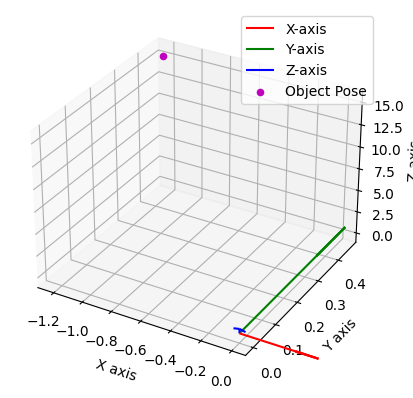

In [18]:
#%% Part C: Select a random image and plot pose
# Select a random image from the processed set
random_image_path = random.choice(images)
random_image = cv2.imread(random_image_path)
cv2.imshow('Random Image', random_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Assuming we use the first rvec and tvec from earlier (adjust if necessary)
rvec_random = rvec1
tvec_random = tvec1

#%% Part D: Find the pose of an object at [2, 5, 0] in the world frame
# Coordinates of the object in the world frame
P_world = np.array([2, 5, 0, 1])

# Construct extrinsic matrix for the random image using the random rvec and tvec
R_random, _ = cv2.Rodrigues(rvec_random)  # Convert rotation vector to matrix
extrinsic_random = np.hstack((R_random, tvec_random))

# Append [0, 0, 0, 1] to make it 4x4 homogeneous matrix
extrinsic_random = np.vstack((extrinsic_random, [0, 0, 0, 1]))

# Apply extrinsic transformation to world point
P_camera = extrinsic_random @ P_world

# Print the transformed point in the camera frame
print(f"Pose of the object in the camera frame: {P_camera[:3]}")

#%% Plotting the object pose in camera frame
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the camera's origin (0, 0, 0)
ax.quiver(0, 0, 0, 1, 0, 0, length=0.5, color='r', label='X-axis')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.5, color='g', label='Y-axis')
ax.quiver(0, 0, 0, 0, 0, 1, length=0.5, color='b', label='Z-axis')

# Plot the object in camera frame
ax.scatter(P_camera[0], P_camera[1], P_camera[2], color='m', label='Object Pose')

# Set labels and show the plot
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()
plt.show()

# Close the pop-up windows to break the cell

# Question 4

7/7 [==============================] - 0s 783us/step

Model Performance Summary:
Model               Learning Rate  R² Train    R² Test     RMSE Train  RMSE Test   
Model 1 (LR=0.001)  0.001          -6788403.543705-10729238.241589129062.369804158465.810647
Model 1 (LR=0.0001) 0.0001         0.996704    0.994831    2.843738    3.478221    
Model 2 (LR=0.001)  0.001          0.971546    0.956726    8.355729    10.063909   
Model 2 (LR=0.0001) 0.0001         0.640390    0.598941    29.705127   30.637617   
Model 3 (LR=0.001)  0.001          -14.528981  -14.721807  195.203348  191.823734  
Model 3 (LR=0.0001) 0.0001         -26.236050  -26.624582  258.516246  254.272253  
Model 4 (LR=0.001)  0.001          0.995356    0.991937    3.375784    4.344165    
Model 4 (LR=0.0001) 0.0001         0.877486    0.860244    17.338363   18.085775   
Model 5 (LR=0.001)  0.001          0.997000    0.993054    2.713309    4.031977    
Model 5 (LR=0.0001) 0.0001         0.882121    0.855148    17.007225  

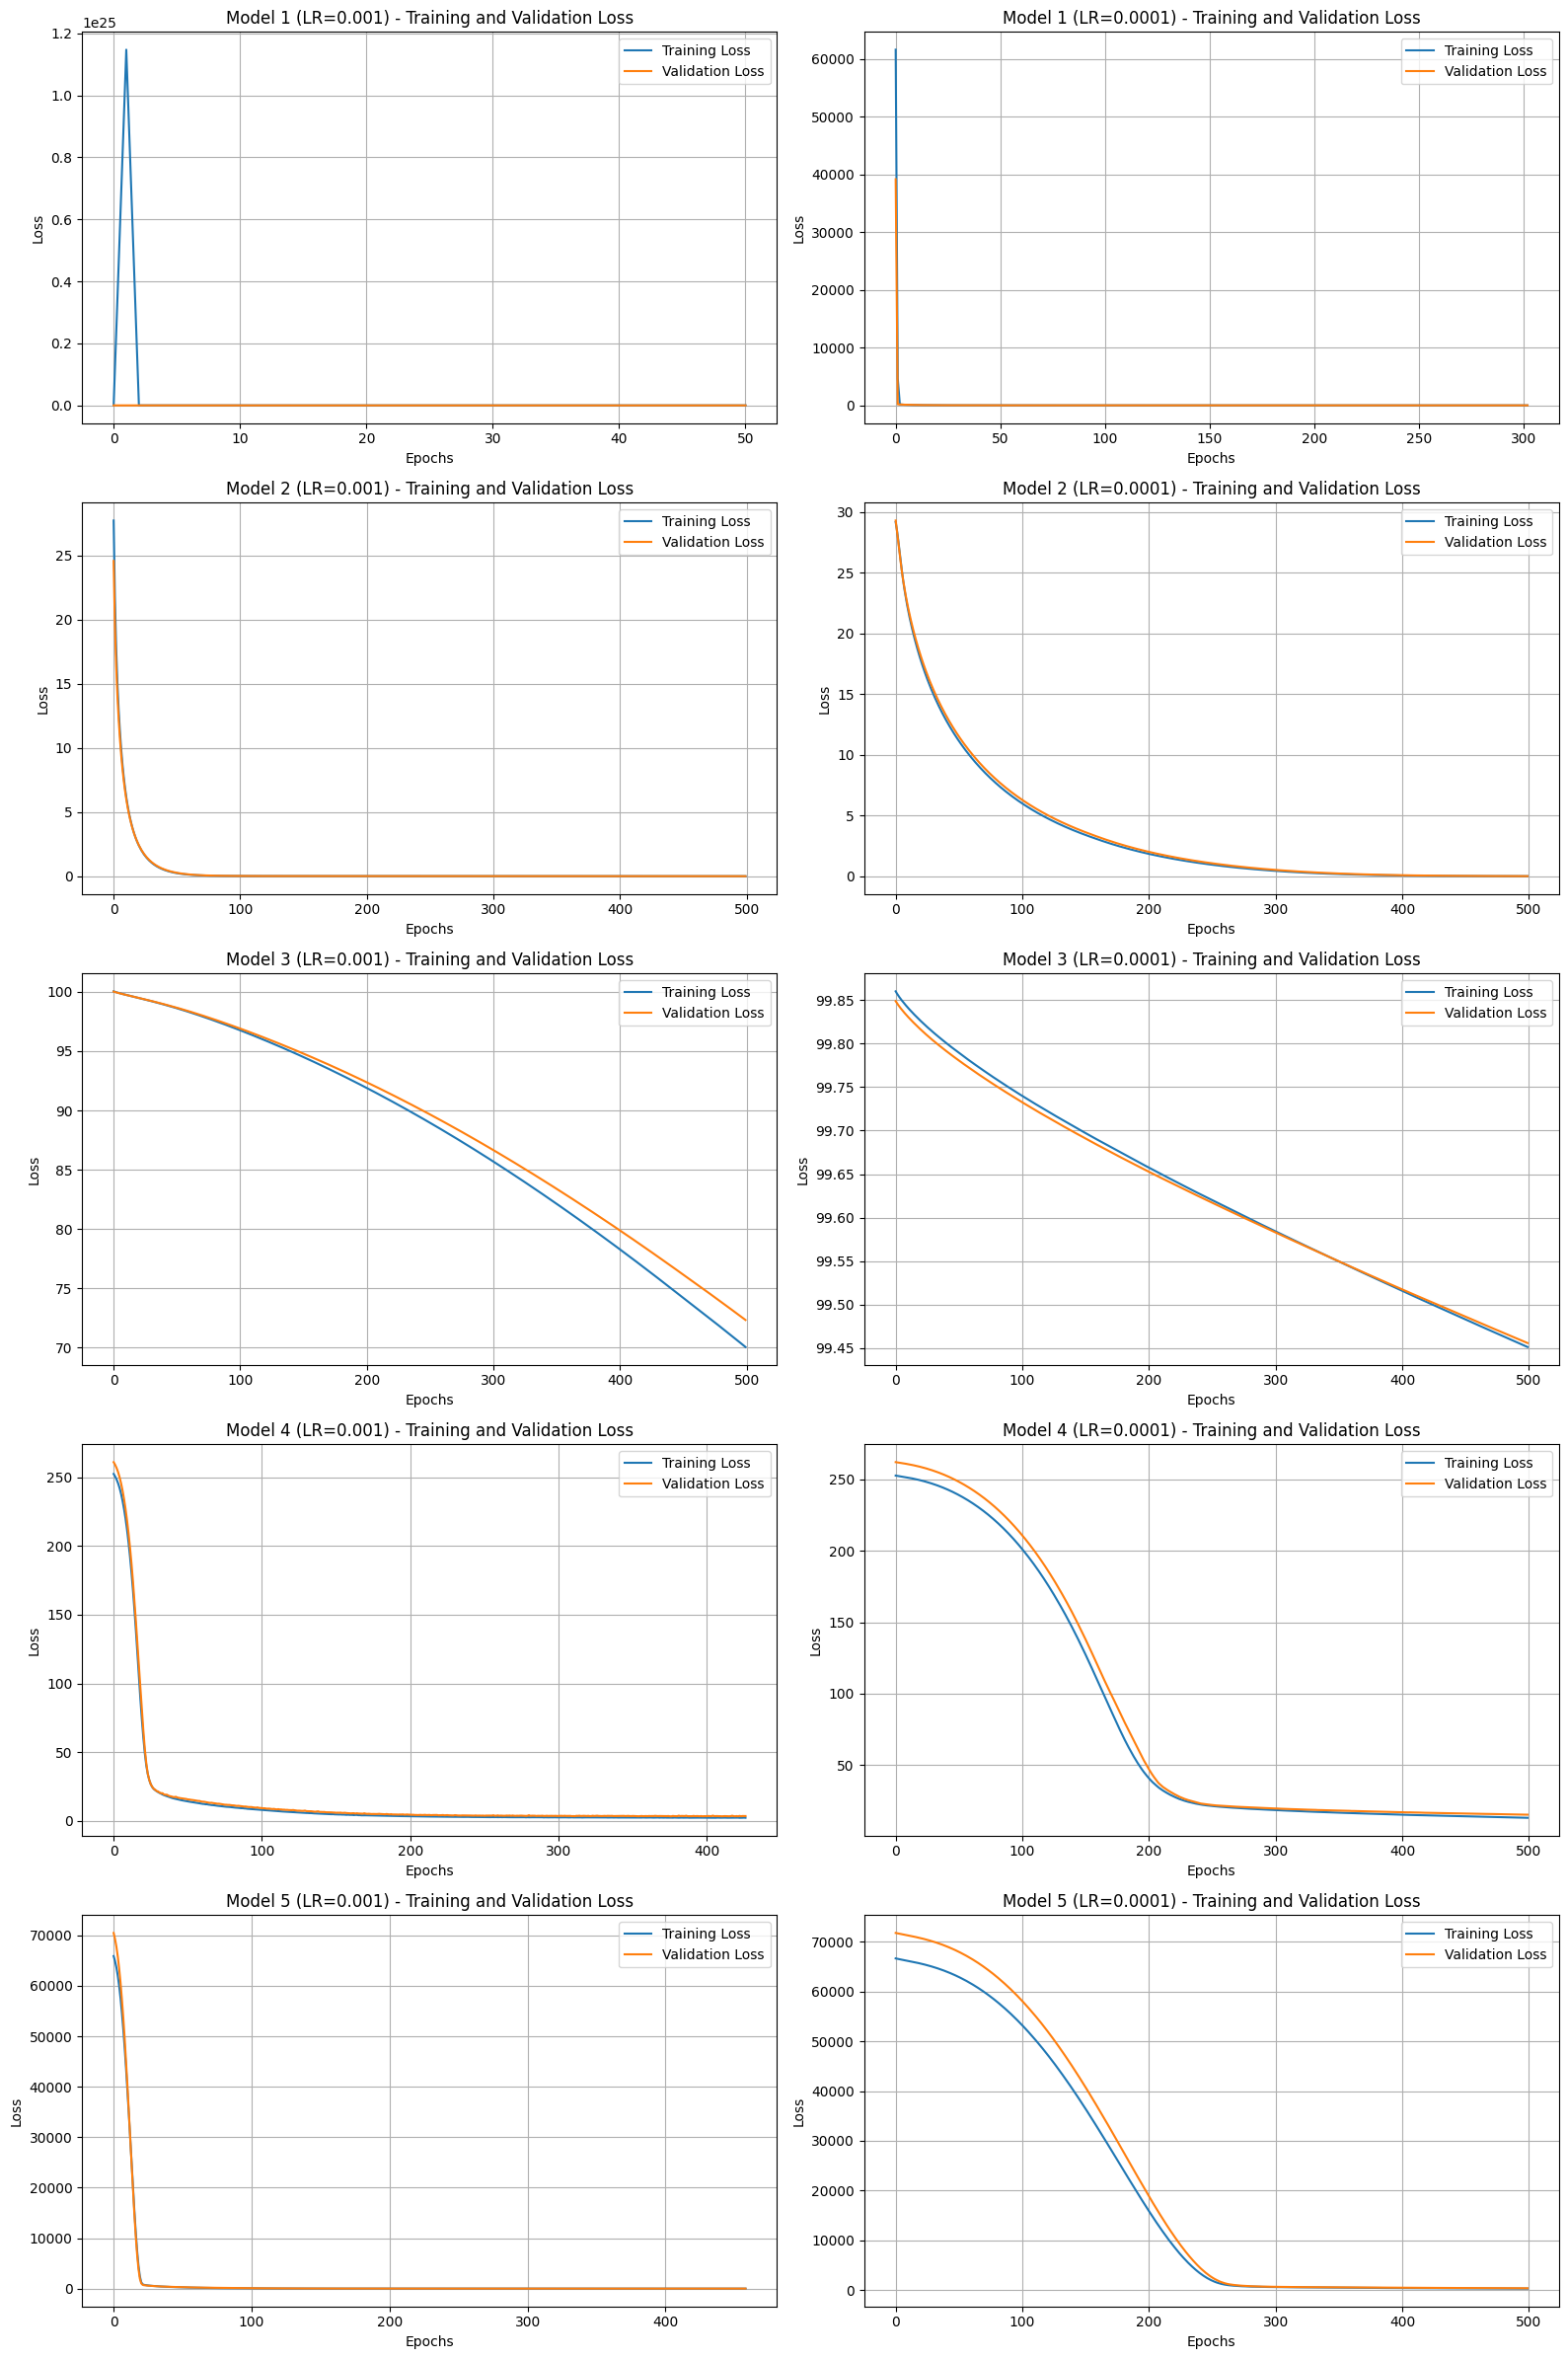

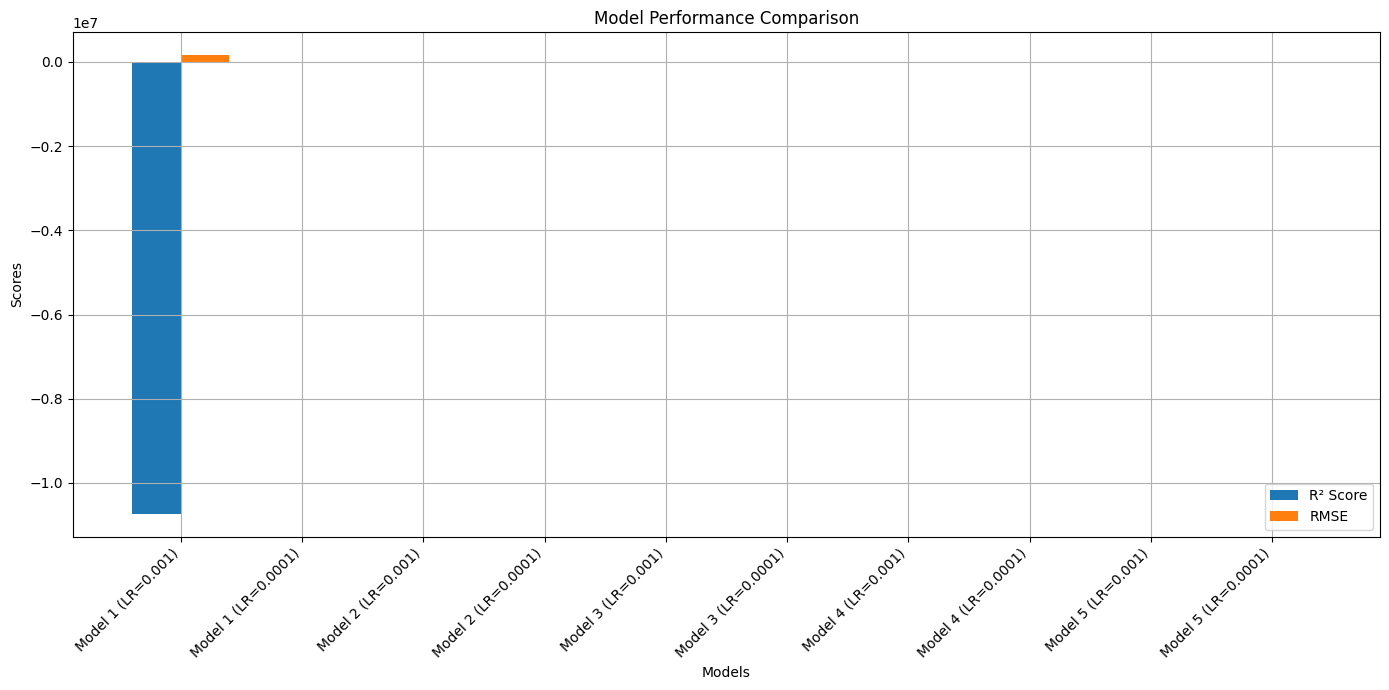

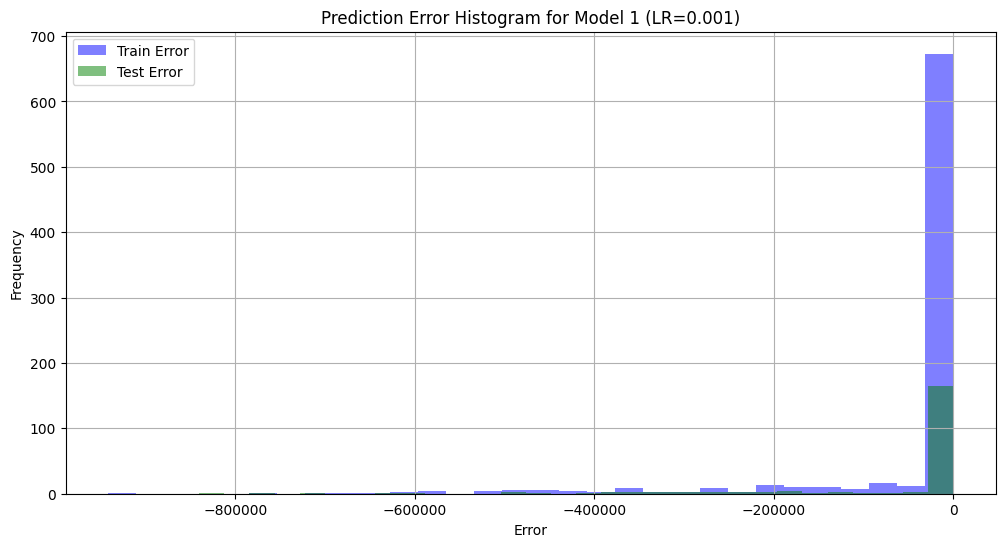

Model 1 (LR=0.001) Train Error: Mean = -42105.28, Std = 122000.99
Model 1 (LR=0.001) Test Error: Mean = -56696.11, Std = 147976.23


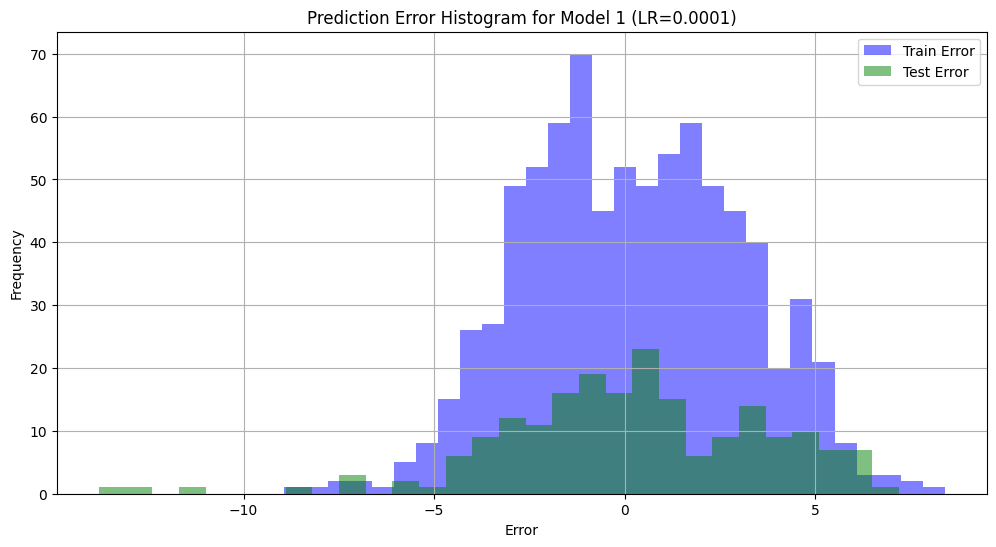

Model 1 (LR=0.0001) Train Error: Mean = 0.22, Std = 2.84
Model 1 (LR=0.0001) Test Error: Mean = 0.20, Std = 3.47


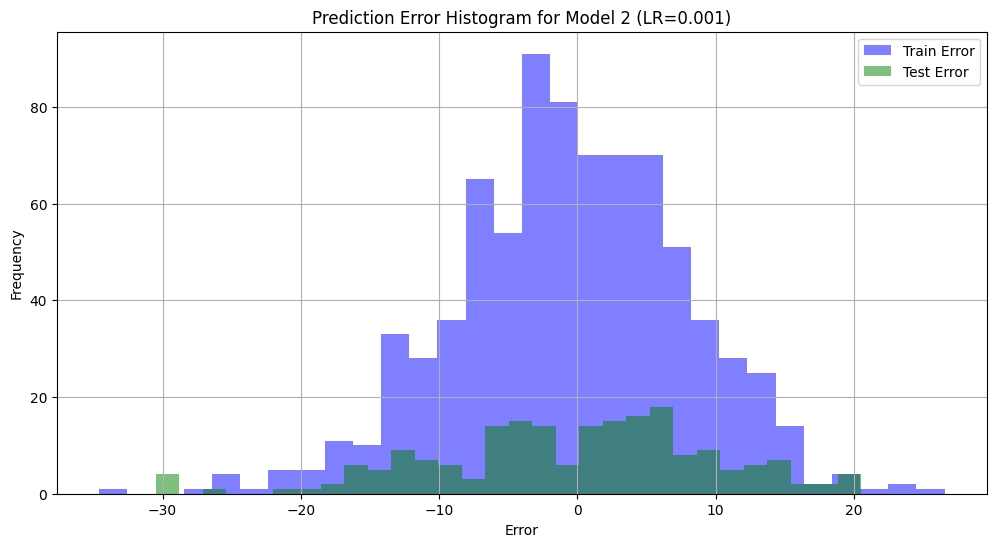

Model 2 (LR=0.001) Train Error: Mean = -0.60, Std = 8.33
Model 2 (LR=0.001) Test Error: Mean = -0.33, Std = 10.06


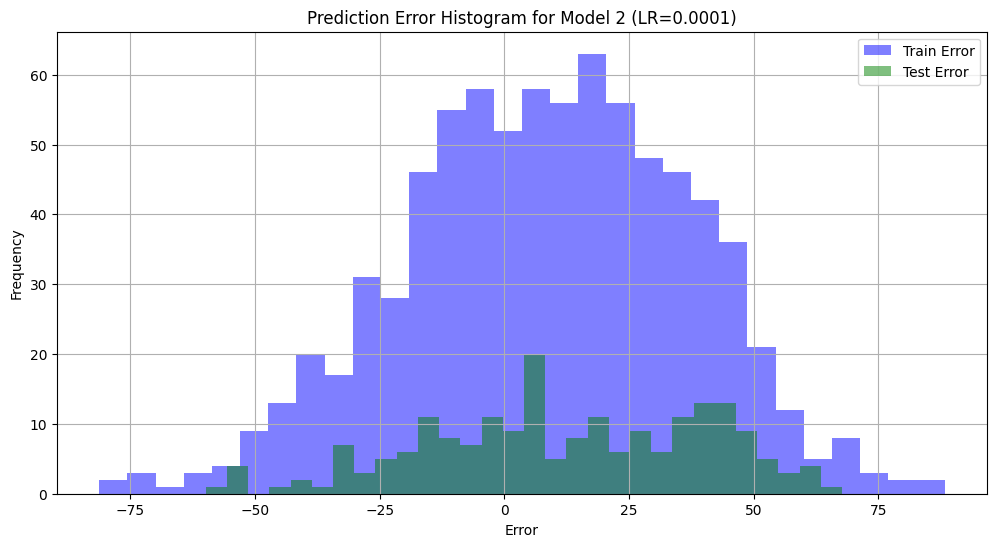

Model 2 (LR=0.0001) Train Error: Mean = 8.30, Std = 28.52
Model 2 (LR=0.0001) Test Error: Mean = 12.31, Std = 28.06


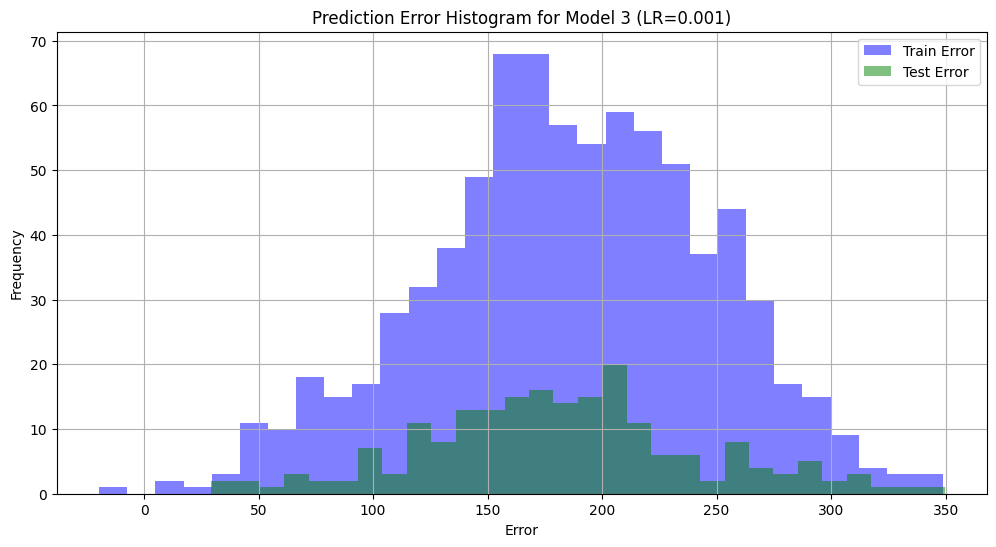

Model 3 (LR=0.001) Train Error: Mean = 185.21, Std = 61.67
Model 3 (LR=0.001) Test Error: Mean = 181.87, Std = 60.99


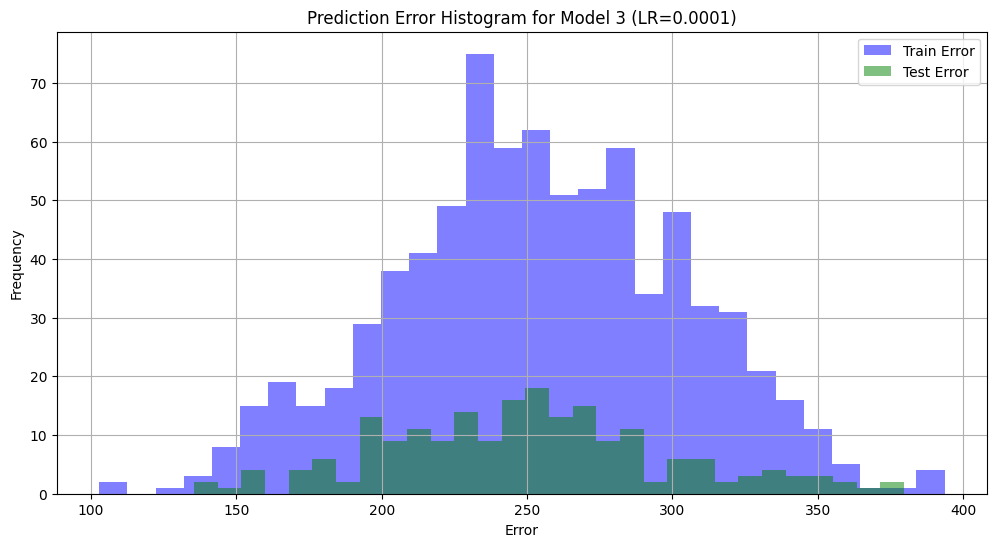

Model 3 (LR=0.0001) Train Error: Mean = 253.70, Std = 49.69
Model 3 (LR=0.0001) Test Error: Mean = 249.60, Std = 48.52


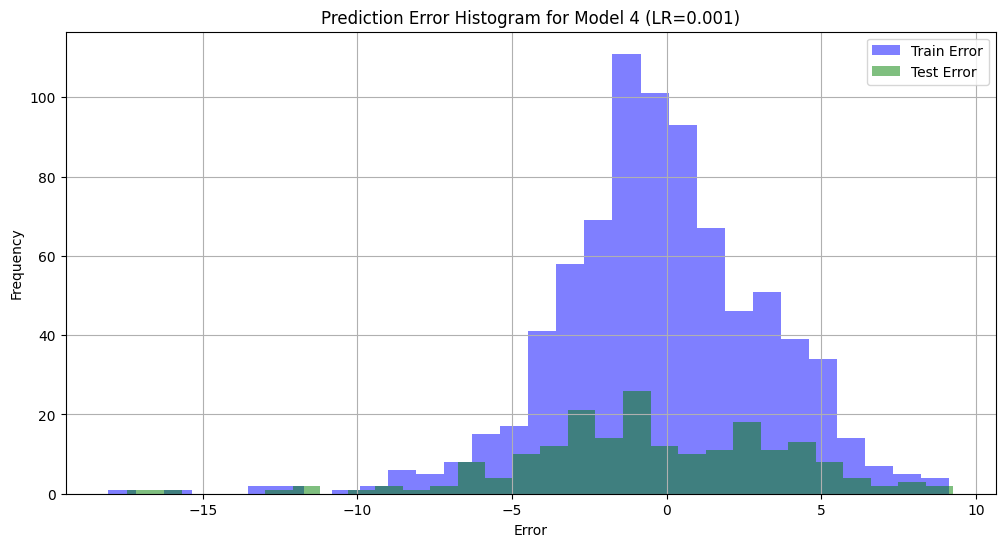

Model 4 (LR=0.001) Train Error: Mean = -0.19, Std = 3.37
Model 4 (LR=0.001) Test Error: Mean = -0.49, Std = 4.32


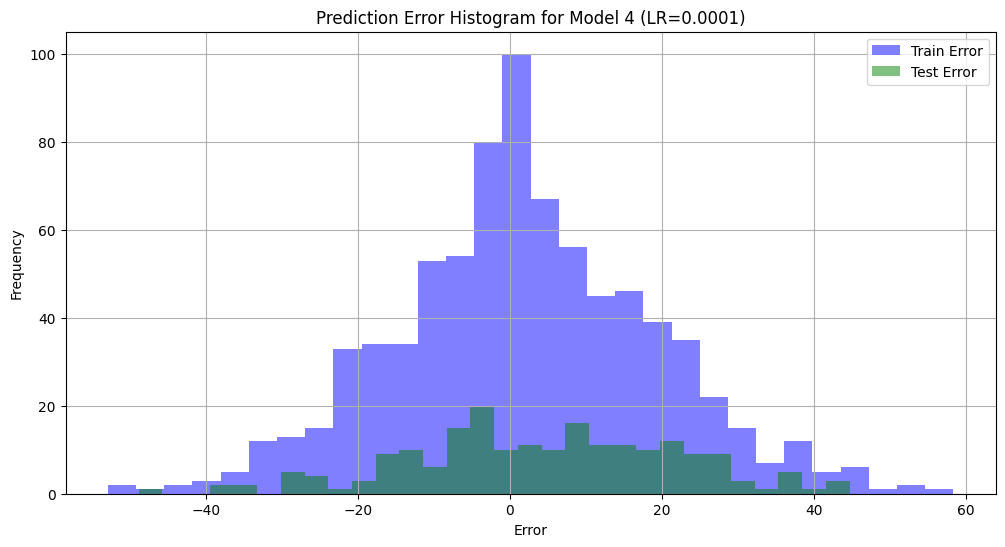

Model 4 (LR=0.0001) Train Error: Mean = 1.92, Std = 17.23
Model 4 (LR=0.0001) Test Error: Mean = 4.36, Std = 17.55


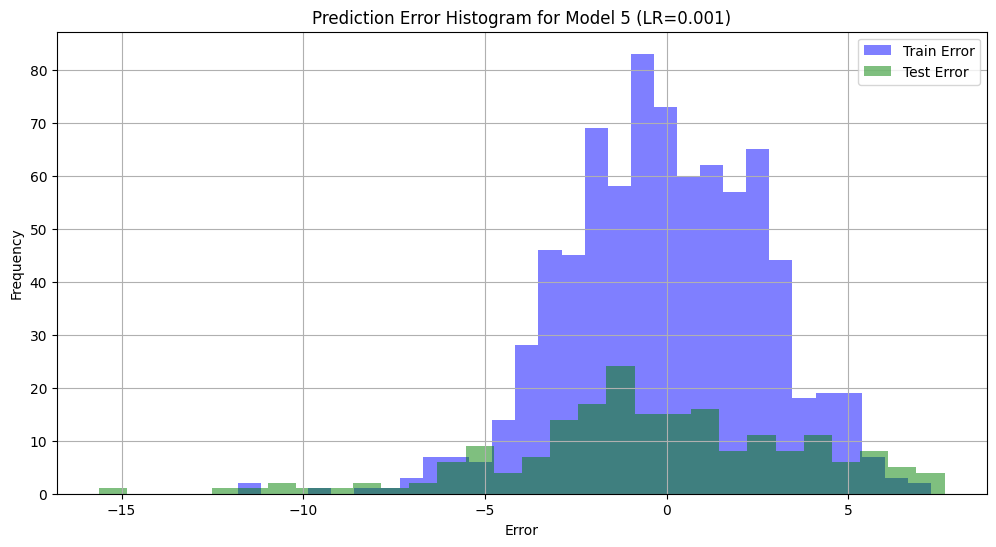

Model 5 (LR=0.001) Train Error: Mean = -0.06, Std = 2.71
Model 5 (LR=0.001) Test Error: Mean = -0.39, Std = 4.01


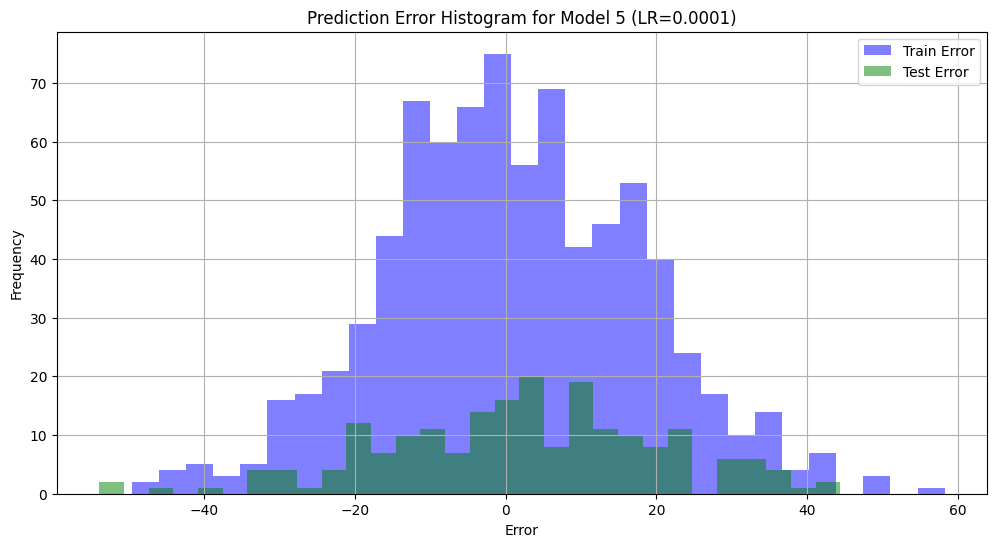

Model 5 (LR=0.0001) Train Error: Mean = 0.93, Std = 16.98
Model 5 (LR=0.0001) Test Error: Mean = 2.41, Std = 18.25


In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error as mse
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
n_samples = 1000  # Number of samples
n_features = 10   # Number of features

# Random feature matrix (X) and target variable (y)
X = np.random.rand(n_samples, n_features) * 100  # Features are random values between 0 and 100
y = np.dot(X, np.random.rand(n_features)) + np.random.rand(n_samples) * 10  # Target is a linear combination of features with some noise

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to create and compile the model
def create_model(optimizer, loss):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model

# Early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Define models with different optimizers and losses
base_models = [
    {'name': 'Model 1', 'optimizer': tf.keras.optimizers.SGD, 'loss': tf.keras.losses.MeanSquaredError()},
    {'name': 'Model 2', 'optimizer': tf.keras.optimizers.Adam, 'loss': tf.keras.losses.MeanSquaredLogarithmicError()},
    {'name': 'Model 3', 'optimizer': tf.keras.optimizers.Adagrad, 'loss': tf.keras.losses.MeanAbsolutePercentageError()},
    {'name': 'Model 4', 'optimizer': tf.keras.optimizers.RMSprop, 'loss': tf.keras.losses.MeanAbsoluteError()},
    {'name': 'Model 5', 'optimizer': tf.keras.optimizers.RMSprop, 'loss': tf.keras.losses.MeanSquaredError()},
]

learning_rates = [0.001, 0.0001]

# Train each model with both learning rates and store the results
results = []
for i in range(5):
    epochs=500
    if i == 5:
        epochs=200
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    for lr in learning_rates:
        model_name = f"{base_models[i]['name']} (LR={lr})"
        optimizer = base_models[i]['optimizer'](learning_rate=lr)
        loss = base_models[i]['loss']
        
        model = create_model(optimizer=optimizer, loss=loss)
        history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[early_stopping], verbose=0)
        
        y_train_pred = model.predict(X_train).flatten()
        y_test_pred = model.predict(X_test).flatten()
        
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        rmse_train = np.sqrt(mse(y_train, y_train_pred))
        rmse_test = np.sqrt(mse(y_test, y_test_pred))

        results.append({
            'model': model_name,
            'learning_rate': lr,
            'r2_train': r2_train,
            'r2_test': r2_test,
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'total_params': model.count_params(),
            'history': history,
            'train_errors': y_train - y_train_pred,
            'test_errors': y_test - y_test_pred,
        })

# Print R² and RMSE scores for each model and learning rate
print("\nModel Performance Summary:")
print(f"{'Model':<20}{'Learning Rate':<15}{'R² Train':<12}{'R² Test':<12}{'RMSE Train':<12}{'RMSE Test':<12}")
for result in results:
    print(f"{result['model']:<20}{result['learning_rate']:<15}{result['r2_train']:<12.6f}{result['r2_test']:<12.6f}{result['rmse_train']:<12.6f}{result['rmse_test']:<12.6f}")

# Fig. 1: Training and Validation Loss for each model
plt.figure(figsize=(16, 24))
for i, result in enumerate(results, start=1):
    plt.subplot(5, 2, i)
    plt.plot(result['history'].history['loss'], label='Training Loss')
    plt.plot(result['history'].history['val_loss'], label='Validation Loss')
    plt.title(f'{result["model"]} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

# Fig. 3: Comparison of Model Performance
model_names = [result['model'] for result in results]
r2_scores = [result['r2_test'] for result in results]
rmse_scores = [result['rmse_test'] for result in results]

plt.figure(figsize=(14, 7))
x = np.arange(len(model_names))

plt.bar(x - 0.2, r2_scores, 0.4, label='R² Score')
plt.bar(x + 0.2, rmse_scores, 0.4, label='RMSE')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Prediction error histograms for each model
for i, result in enumerate(results):
    model_name = result['model']
    train_errors = result['train_errors']
    test_errors = result['test_errors']

    plt.figure(figsize=(12, 6))
    plt.hist(train_errors, bins=30, alpha=0.5, label='Train Error', color='blue')
    plt.hist(test_errors, bins=30, alpha=0.5, label='Test Error', color='green')
    plt.title(f'Prediction Error Histogram for {model_name}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

    mean_train = np.mean(train_errors)
    std_train = np.std(train_errors)
    mean_test = np.mean(test_errors)
    std_test = np.std(test_errors)

    print(f'{model_name} Train Error: Mean = {mean_train:.2f}, Std = {std_train:.2f}')
    print(f'{model_name} Test Error: Mean = {mean_test:.2f}, Std = {std_test:.2f}')


# Question 5

Epoch 1/50
22/22 [==============================] - 0s 7ms/step - loss: 106.1521 - val_loss: 91.2170
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 70.7532 - val_loss: 62.0764
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 43.7018 - val_loss: 36.2098
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 22.7709 - val_loss: 17.7434
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 11.1207 - val_loss: 8.1993
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 5.5276 - val_loss: 4.7223
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 3.0506 - val_loss: 3.3453
Epoch 8/50
22/22 [==============================] - 0s 3ms/step - loss: 1.9201 - val_loss: 2.3262
Epoch 9/50
22/22 [==============================] - 0s 3ms/step - loss: 1.2427 - val_loss: 1.7574
Epoch 10/50
22/22 [==============================] - 0s 3ms/step - loss: 0.8751 - val_loss: 1.4423
Epoch 11/

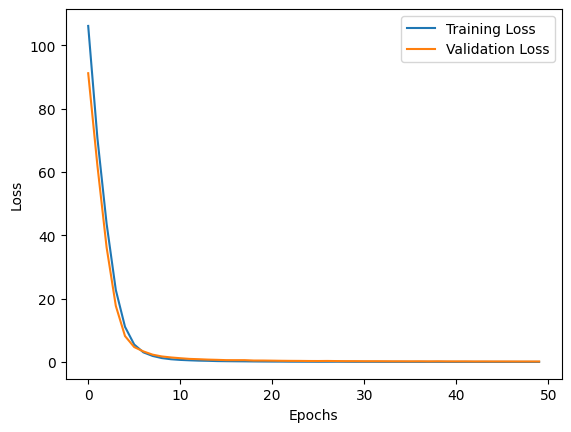

In [3]:
# Step 1: Generate the data
np.random.seed(42)
x = np.random.randn(1000, 100)
beta_0 = 7
beta_1 = 1
y = beta_0 + beta_1 * x.sum(axis=1)

# Step 2: Split the data
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.33, random_state=42)

# Step 3: Define the CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(100, 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train the model
history = model.fit(x_train[..., np.newaxis], y_train, epochs=50, validation_data=(x_val[..., np.newaxis], y_val))

# Step 5: Evaluate the model
y_pred = model.predict(x_test[..., np.newaxis])
rmse = np.sqrt(np.mean((y_test - y_pred.squeeze())**2))
print(f'RMSE: {rmse}')

# Plot the RMSE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Question 6

In [16]:
# Define paths for the Original_img and augment folders
original_base_folder = "original_img"
augment_folder = "augment_img"

# Ensure the augment folder exists
os.makedirs(augment_folder, exist_ok=True)

# Initialize a counter for naming images
counter = 1

# Define augmentation functions
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def blur_image(image, ksize=5):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)

# Function to augment images for each color folder
def augment_images(input_folder, target_count=600):
    global counter
    images = os.listdir(input_folder)
    original_count = len(images)
    
    # Augment images until the total count reaches target_count
    while original_count < target_count:
        image_file = random.choice(images)
        image_path = os.path.join(input_folder, image_file)
        image = cv2.imread(image_path)
        
        # Randomly apply transformations
        if random.choice([True, False]):
            image = rotate_image(image, angle=random.randint(-30, 30))
        if random.choice([True, False]):
            image = blur_image(image, ksize=random.choice([3, 5, 7]))
        if random.choice([True, False]):
            image = flip_image(image, flip_code=random.choice([-1, 0, 1]))
        
        # Save augmented image with a new name in the augment folder
        output_path = os.path.join(augment_folder, f"img_{counter}.jpg")
        cv2.imwrite(output_path, image)
        
        counter += 1
        original_count += 1

# Copy and rename original images into the augment folder
def copy_and_rename_original_images(source_folder):
    global counter
    for image_file in os.listdir(source_folder):
        image_path = os.path.join(source_folder, image_file)
        
        # Ensure the file is an image
        if os.path.isfile(image_path) and image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            new_image_name = f"img_{counter}.jpg"
            new_image_path = os.path.join(augment_folder, new_image_name)
            shutil.copy(image_path, new_image_path)
            counter += 1

# Process each color folder in Original_img
color_folders = ['blue', 'pink', 'red', 'white']
for color in color_folders:
    color_folder_path = os.path.join(original_base_folder, color)
    
    # First, augment images to reach 600 total images for each color
    augment_images(color_folder_path, target_count=600)
    
    # Then, copy the original images to the augment folder
    copy_and_rename_original_images(color_folder_path)

In [ ]:
train_folder = "train"
val_folder = "val"
test_folder = "test"

# Function to split data into train, val, and test sets
def split_data(input_folder, train_folder, val_folder, test_folder):
    images = os.listdir(input_folder)
    
    # Split images into train (80%), val (10%), and test (10%)
    train, test = train_test_split(images, test_size=0.2, random_state=42)
    val, test = train_test_split(test, test_size=0.5, random_state=42)
    
    for img in train:
        shutil.move(os.path.join(input_folder, img), os.path.join(train_folder, img))
    for img in val:
        shutil.move(os.path.join(input_folder, img), os.path.join(val_folder, img))
    for img in test:
        shutil.move(os.path.join(input_folder, img), os.path.join(test_folder, img))

split_data(augment_folder, train_folder, val_folder, test_folder)

# Question 7

Epoch 1/100
7/7 [==============================] - 3s 60ms/step - loss: 2.2373 - accuracy: 0.2375 - val_loss: 2.2306 - val_accuracy: 0.6000
Epoch 2/100
7/7 [==============================] - 0s 42ms/step - loss: 1.5715 - accuracy: 0.4775 - val_loss: 2.1035 - val_accuracy: 0.7000
Epoch 3/100
7/7 [==============================] - 0s 40ms/step - loss: 1.3377 - accuracy: 0.5600 - val_loss: 2.0645 - val_accuracy: 0.8600
Epoch 4/100
7/7 [==============================] - 0s 40ms/step - loss: 1.0929 - accuracy: 0.6350 - val_loss: 1.9778 - val_accuracy: 0.8500
Epoch 5/100
7/7 [==============================] - 0s 40ms/step - loss: 0.9318 - accuracy: 0.6475 - val_loss: 1.8993 - val_accuracy: 0.8400
Epoch 6/100
7/7 [==============================] - 0s 40ms/step - loss: 0.8399 - accuracy: 0.7100 - val_loss: 1.9253 - val_accuracy: 0.8700
Epoch 7/100
7/7 [==============================] - 0s 40ms/step - loss: 0.7763 - accuracy: 0.7275 - val_loss: 1.8031 - val_accuracy: 0.8500
Epoch 8/100
7/7 [===

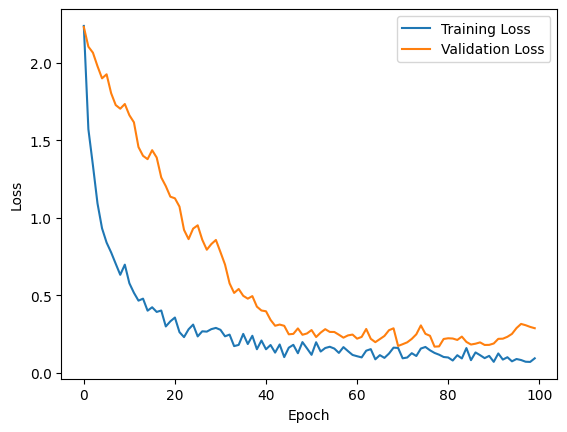

16/16 [==============================] - 0s 8ms/step


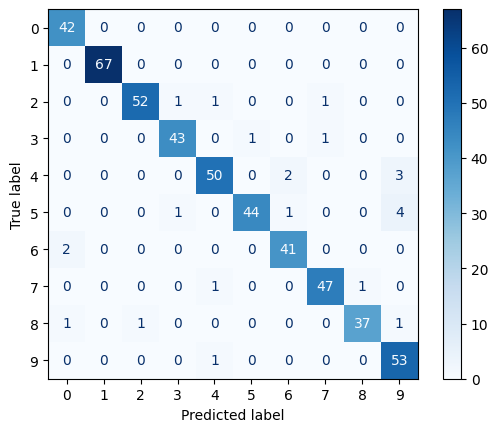

Accuracy: 95.20%


In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reduce training set size for efficiency
x_train, y_train = x_train[:500].astype('float32') / 255.0, y_train[:500]
x_test = x_test.astype('float32') / 255.0

# Reshape for Conv2D layer and split validation set
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_val, y_val = x_train[-100:], y_train[-100:]
x_train, y_train = x_train[:-100], y_train[:-100]

# Define and compile the model
model = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=100, batch_size=64, 
                    validation_data=(x_val, y_val), 
                    callbacks=[early_stopping])

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Display confusion matrix for the first 500 test samples
y_pred = np.argmax(model.predict(x_test[:500]), axis=1)
conf_matrix = confusion_matrix(y_test[:500], y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(10)).plot(cmap=plt.cm.Blues)
plt.show()

# Print model accuracy
accuracy = np.mean(y_pred == y_test[:500])
print(f'Accuracy: {accuracy * 100:.2f}%')
